In [1]:
import warnings

import numpy as np

warnings.simplefilter("ignore", UserWarning)
import os.path

import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker

In [3]:
def preprocess_for_param(param):
    print(f"<<<<<<<<<<<<< {param} >>>>>>>>>>>>> ")
    dfs = []
    for year in range(2015, 2023):
        filepath = f'data/Wyniki pomiarów z {year} roku/{year}_{param}.xlsx'
        if os.path.exists(filepath):
            print(f"Processing data from {year} for parameter: {param}")
            df = pd.read_excel(filepath, header=None)
            if year in [2016, 2018]:
                res = df.iloc[1]
                df = df[df[0].apply(lambda x: (type(x) != str and not pd.isna(x)))]
                df.columns = res
                df.index = pd.to_datetime(df.iloc[:, 0])
            else:
                res = df.loc[df[0] == 'Kod stacji']
                df = df[df[0].apply(lambda x: (type(x) != str and not pd.isna(x)))]
                df.columns = res.iloc[0]
                df.index = pd.to_datetime(df['Kod stacji'])
                
            df.drop(df.columns[0], axis=1, inplace=True)
            df.rename_axis('Date', axis=1, inplace=True)
            filtered_col = [col for col in df if not pd.isna(col) and col.startswith('DsWroc')]
            dfs.append(df[filtered_col])

    pd.concat(dfs).to_excel(f'{param}.xlsx')

parameters = ['SO2_1g', 'SO2_24g', 'PM25_1g', 'PM25_24g', 'PM10_1g', 'PM10_24g', 'O3_1g', 'CO_1g', 'NO2_1g', 'NO2_24g']
# [preprocess_for_param(param) for param in parameters]


In [4]:
def save_columns(year: int) -> None:
    dir_path = f'filtered_data_since_{year}'
    columns = []
    for file in os.listdir(dir_path):
        columns.append((file, list(pd.read_excel(os.path.join(dir_path, file), index_col=0))))    
    
    with open(f'columns_{year}.txt', 'w+') as f:
        [f.write(filename + ': ' + ', '.join(col) + '\n') for filename, col in columns]

# save_columns(2005)
# save_columns(2015)


In [5]:
def read_filtered_data():
    path = 'filtered_data_since_2015'
    return {file.replace('.xlsx', '').split('_')[0]: pd.read_excel(os.path.join(path, file), index_col=0) for file in os.listdir(path)}


In [6]:
from math import trunc
def truncate(number, digits) -> float:
    if len(str(number).split('.')[1]) <= digits:
        return number
    stepper = 10.0 ** digits
    return trunc(stepper * number) / stepper


In [7]:
aqi = [(0, 50), (51, 100), (101, 150), (151, 200), (201, 300)]
pollutants = {
    'PM10': (0, [(0, 54), (55, 154), (155, 254), (255, 354), (355, 424)]),
    'PM25': (1, [(0.0, 9.0), (9.1, 35.4), (35.5, 55.4), (55.5, 125.4), (125.5, 225.4)]),
    'O3': (3, [(0.000, 0.054), (0.055, 0.070), (0.071, 0.085), (0.086, 0.105), (0.106, 0.200)]),
    'CO': (1, [(0.0, 4.4), (4.5, 9.4), (9.5, 12.4), (12.5, 15.4), (15.5, 30.4)]),
    'NO2': (0, [(0, 53), (54, 100), (101, 360), (361, 649), (650, 1249)]),
    'SO2': (1, [(0, 35), (36, 75), (76, 185), (186, 304), (305, 604)])
}

def calculate_aqi(pollutant_value, pollutant_name):
    print(pollutant_value)
    trunc_point, breakpoints = pollutants[pollutant_name]
    bp_idx = -1
    for i, (bot, top) in enumerate(breakpoints):
        if bot <= pollutant_value <= top:
            bp_idx = i
    i_hi, i_lo = aqi[bp_idx]
    bp_hi, bp_lo = breakpoints[bp_idx]
    return round((i_hi - i_lo) / (bp_hi - bp_lo) * (truncate(pollutant_value, trunc_point) - bp_lo) + i_lo)


In [54]:
dfs = read_filtered_data()

In [55]:
dfs

{'SO2':                         DsWrocWybCon
 2015-01-01 01:00:00.000            7
 2015-01-01 02:00:00.000            6
 2015-01-01 03:00:00.005            6
 2015-01-01 04:00:00.010            6
 2015-01-01 05:00:00.015            6
 ...                              ...
 2022-12-31 20:00:00.000      4.94059
 2022-12-31 21:00:00.000      4.75008
 2022-12-31 22:00:00.000      6.36952
 2022-12-31 23:00:00.000      9.03151
 2023-01-01 00:00:00.000      9.69569
 
 [70128 rows x 1 columns],
 'NO2':                         DsWrocAlWisn DsWrocBartni DsWrocWybCon
 2015-01-01 01:00:00.000           25           19           20
 2015-01-01 02:00:00.000      28.6413      22.5798       20.498
 2015-01-01 03:00:00.005      32.2744      23.3402       20.999
 2015-01-01 04:00:00.010      31.7648      19.6545       21.564
 2015-01-01 05:00:00.015      28.8661      17.4184       20.286
 ...                              ...          ...          ...
 2022-12-31 20:00:00.000      35.2228      6.64792   

In [101]:
missing_data = {}
coff = {'SO2': 5, 'O3': 1 / 500, 'PM10': 1, 'PM25': 1, 'NO2': 1, 'CO': 10}
final_df = None
for key, df in dfs.items():
    print(key)
    df: pd.DataFrame = df.replace(',', '.', regex=True).apply(pd.to_numeric)
    df['Mean'] = df.mean(axis=1)
    df = df.fillna(df.mean())
    
    if key in ['O3', 'CO'] :
        df = df.resample('8h').mean()
    missing_data[key] = (df['Mean'].isna().sum(), len(df.index))
    df['AQI'] = df['Mean'].apply(lambda x: calculate_aqi(x * coff[key], key))
    mean_df = df['AQI'].resample('1d').max()
    if final_df is None:
        final_df = mean_df.rename(key).to_frame()
    else:
        final_df=final_df.merge(mean_df.rename(key),left_index= True, right_index=True)
#     df = df.drop(df.columns.difference(['Mean', 'AQI']), axis=1)
    display(df)
    # df.to_excel(f'finished_{key}.xlsx')
print(missing_data)

SO2
35.0
30.0
30.0
30.0
30.0
30.0
25.0
20.0
20.0
25.0
25.0
25.0
35.0
40.0
35.0
35.0
30.0
30.0
35.0
40.0
40.0
40.0
35.0
45.0
40.0
40.0
35.0
40.0
35.0
30.0
25.0
30.0
35.0
35.0
30.0
25.0
20.0
20.0
20.0
25.0
25.0
20.0
20.0
20.0
20.0
20.0
25.0
20.0
20.0
20.0
20.0
20.0
20.0
15.0
20.0
20.0
15.0
15.0
15.0
15.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
20.0
25.0
35.0
40.0
30.0
25.0
25.0
25.0
20.0
25.0
25.0
30.0
30.0
30.0
30.0
25.0
25.0
25.0
25.0
30.0
30.0
25.0
15.0
20.0
15.0
15.0
15.0
15.0
15.0
20.0
20.0
25.0
20.0
20.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
20.0
15.0
20.0
20.0
15.0
15.0
20.0
15.0
20.0
30.0
35.0
45.0
35.0
35.0
45.0
70.0
70.0
65.0
60.0
60.0
80.0
135.0
120.0
150.0
155.0
135.0
155.0
175.0
215.0
215.0
200.0
195.0
190.0
170.0
125.0
95.0
70.0
65.0
80.0
75.0
70.0
70.0
60.0
55.0
50.0
55.0
55.0
55.0
55.0
55.0
55.0
65.0
60.0
70.0
75.0
85.0
21.76589636354389
115.0
105.0
90.0
85.0
75.0
85.0
85.0
85.0
75.0
65.0
60.0
50.0
40.0
35.0
35

14.6167
12.368300000000001
9.82765
9.429549999999999
10.345899999999999
10.585249999999998
12.278649999999999
15.54245
15.99245
21.07545
19.711199999999998
17.05485
43.51965
30.7621
14.907649999999999
13.06445
10.7119
15.731599999999998
12.95495
11.78815
16.6071
14.577150000000001
11.09325
11.85385
9.746749999999999
12.163649999999999
13.09355
14.5617
14.17815
14.6181
15.136050000000001
14.75605
14.44495
16.9694
18.131349999999998
17.46635
16.6515
16.8248
15.406899999999998
14.710049999999999
13.964749999999999
17.21055
24.047800000000002
40.229350000000004
48.61415
37.9219
27.36005
23.09065
20.103749999999998
16.9821
14.87845
13.88485
13.0379
17.11815
15.9129
16.00165
15.0917
17.15865
16.188
17.653000000000002
16.7434
14.95145
15.4588
16.35705
15.753699999999998
13.8215
12.13365
12.4621
12.5225
16.3382
15.79315
17.15445
13.91475
16.79945
12.850850000000001
11.821
10.320800000000002
11.3493
11.168949999999999
10.58305
10.312149999999999
11.58895
16.79465
14.07695
13.59075
11.8887
11.27

27.081599999999998
27.13765
24.5783
21.9108
20.454050000000002
18.1535
18.74895
17.6552
18.86825
20.51085
18.0816
16.78315
16.620449999999998
17.04655
16.70315
17.636400000000002
17.80995
18.0758
17.945500000000003
17.188950000000002
17.5471
18.51175
18.43205
18.3393
17.05095
17.6804
17.750300000000003
17.4171
17.16495
17.7699
17.0051
17.3961
15.829699999999999
16.77985
17.4554
16.21065
16.875500000000002
16.70845
17.9792
17.406
17.16725
16.94005
17.714399999999998
17.86955
16.3234
17.23705
18.1383
17.711
17.63285
17.1126
17.4342
17.22015
16.87245
17.3986
17.4479
17.2725
16.5762
17.25645
17.16685
17.60565
18.1025
18.057650000000002
17.179850000000002
18.464100000000002
17.8327
17.47335
18.2572
17.4776
16.5992
16.84505
16.9672
17.5702
17.272199999999998
17.096249999999998
18.3414
16.6765
18.036
17.32095
16.76715
16.3286
21.76589636354389
16.4129
16.22835
17.1782
17.0543
17.11975
17.1568
16.796599999999998
17.342550000000003
18.1317
16.974050000000002
16.8601
17.9249
17.2274
18.04695
16.

DsWrocWybCon     Mean  AQI
2015-01-01 01:00:00.000       7.00000  7.00000   50
2015-01-01 02:00:00.000       6.00000  6.00000   43
2015-01-01 03:00:00.005       6.00000  6.00000   43
2015-01-01 04:00:00.010       6.00000  6.00000   43
2015-01-01 05:00:00.015       6.00000  6.00000   43
...                               ...      ...  ...
2022-12-31 20:00:00.000       4.94059  4.94059   35
2022-12-31 21:00:00.000       4.75008  4.75008   34
2022-12-31 22:00:00.000       6.36952  6.36952   45
2022-12-31 23:00:00.000       9.03151  9.03151   62
2023-01-01 00:00:00.000       9.69569  9.69569   67

[70128 rows x 3 columns]

NO2
21.333333333333332
23.906366666666667
25.537866666666662
24.327766666666665
22.190166666666666
20.7189
17.539033333333332
15.588999999999999
14.593166666666667
15.086933333333334
14.605233333333336
16.9486
17.457800000000002
18.050366666666665
21.668366666666667
27.454700000000003
42.17933333333333
58.253166666666665
52.507200000000005
47.735233333333326
48.92513333333333
37.12003333333333
30.368066666666667
28.295599999999997
25.308566666666668
23.101733333333332
24.422966666666667
24.0835
20.181166666666666
23.18554
29.764533333333333
32.10466666666667
32.457366666666665
30.83983333333333
26.294966666666667
29.223399999999998
32.08926666666667
38.049733333333336
38.93673333333333
25.148266666666668
20.30163333333333
21.333133333333333
23.820733333333333
20.831733333333336
23.837633333333333
21.420366666666666
14.842033333333333
14.847066666666665
9.270506666666668
11.776560000000002
10.816026666666666
11.058520000000001
7.539996666666667
9.498213333333334
13.8011
9.13443
11.31092

24.2337
24.02949666666667
34.86315
25.074640000000002
24.244970000000006
21.51436
22.05282
22.234843333333334
25.29564666666667
37.8086
47.86336666666667
36.89666666666667
27.80801
24.6743
25.7628
19.924533333333333
20.705766666666666
19.757433333333335
20.09736666666667
18.029566666666668
12.643936666666667
16.008656666666667
16.791496666666664
15.879249999999999
15.441646666666665
10.271026666666668
9.38839
9.142513333333333
9.740070000000001
9.913013333333334
11.356146666666667
16.881980000000002
20.306313333333332
25.520666666666667
28.137066666666666
25.252033333333333
25.106033333333333
20.326466666666665
13.285033333333333
12.631383333333332
10.86345
13.959446666666667
15.761246666666667
20.6452
21.794633333333334
21.350199999999997
22.3592
29.11252
28.19033333333333
28.0532
27.1541
22.782300000000003
16.022836666666667
20.755006666666667
24.660413333333327
23.90451333333333
30.101243333333333
30.460863333333332
23.18259666666667
21.495473333333337
16.611703333333335
24.81668999

DsWrocAlWisn  DsWrocBartni  DsWrocWybCon       Mean  \
2015-01-01 01:00:00.000       25.0000      19.00000      20.00000  21.333333   
2015-01-01 02:00:00.000       28.6413      22.57980      20.49800  23.906367   
2015-01-01 03:00:00.005       32.2744      23.34020      20.99900  25.537867   
2015-01-01 04:00:00.010       31.7648      19.65450      21.56400  24.327767   
2015-01-01 05:00:00.015       28.8661      17.41840      20.28600  22.190167   
...                               ...           ...           ...        ...   
2022-12-31 20:00:00.000       35.2228       6.64792       8.38890  16.753207   
2022-12-31 21:00:00.000       27.5823       4.30944       8.23966  13.377133   
2022-12-31 22:00:00.000       21.6422       4.70384       6.52311  10.956383   
2022-12-31 23:00:00.000       17.2638       6.16083       5.58888   9.671170   
2023-01-01 00:00:00.000       25.5337       5.09407       6.42046  12.349410   

                         AQI  
2015-01-01 01:00:00.000   20  
2015-01-01 02:00:00.000   22  
2015-01-01 03:00:00.005   24  
2015-01-01 04:00:00.010   23  
2015-01-01 05:00:00.015   21  
...                      ...  
2022-12-31 20:00:00.000   15  
2022-12-31 21:00:00.000   12  
2022-12-31 22:00:00.000    9  
2022-12-31 23:00:00.000    8  
2023-01-01 00:00:00.000   11  

[70128 rows x 5 columns]

CO
7.817017142857142
7.2001375
12.3345575
9.621666875
8.5041125
6.550359375
5.335576250000001
6.596304374999999
7.3006174999999995
5.867736875
5.81588625
6.2918675
5.80139875
7.96095
7.82011
5.919138125
6.582333125
9.744325
9.29094125
11.1574125
8.93666625
6.26889375
8.7995075
8.265856874999999
3.3926093749999997
5.17259125
4.51616
3.195908125
5.4257075
3.658355
2.80456125
3.306150625
3.7123675
3.368805
5.3783475
5.258596875
3.8629124999999997
4.98272875
5.572634375
4.1974825
5.292485624999999
7.855828750000001
3.805424375
5.05591625
5.801616875
4.564351875
6.651484375000001
14.141775625
8.3661975
7.114913124999999
9.6216725
7.2893300000000005
7.059760000000001
8.576645625
6.467999375
6.998639375
8.172238125
7.943558749999999
10.541615625
12.795293749999999
11.2445025
7.894725
8.67817125
6.782494375
8.631520625
8.433025
7.3877387500000005
8.841529375
8.438508125
6.8944931249999994
7.0657925
6.594846875
5.022632499999999
5.090735
4.84366125
4.1893775
6.036334999999999
7.841465000000001


4.81680375
5.059679375
3.637910625
4.09103125
4.6575925
4.144528125
4.54808625
4.79458625
4.42072125
4.428631875000001
5.868191875000001
5.2752625
4.322205
4.676381919966931
4.52638125
4.936929375
4.338336875
3.684069375
4.440194375
5.2247025
4.492904375
4.389825625
5.084048125000001
4.294544375
3.92417
4.52412625
4.111428125
5.06936625
4.4231125
4.184683125
4.433005
5.26586375
4.01221875
4.60675625
5.47575625
4.69099625
4.786140669966931
5.051734375
4.699669375
4.778375625
4.60485875
3.0875025000000003
2.97408875
3.273264375
2.798854375
3.24550875
4.232045625
3.6871549999999997
4.509176249999999
5.941378749999999
4.7272575
5.561355624999999
6.333800625
4.824066875
4.60749375
4.624750625
4.1212025
4.62649125
4.895079419966931
5.124559375
4.528095625000001
4.377429375
3.38773875
4.157261875
4.347384375
3.29928
3.793715625
3.9614293750000003
3.6918056249999998
3.6902843749999996
4.5458125
4.511795
3.7528049999999995
4.271431875
4.277098125
3.8683206249999995
4.295208125
3.697011875000000

DsWrocAlWisn  DsWrocWybCon      Mean  AQI
2015-01-01 00:00:00      0.931546      0.631857  0.781702   84
2015-01-01 08:00:00      0.880402      0.559625  0.720014   78
2015-01-01 16:00:00      1.616037      0.850875  1.233456  148
2015-01-02 00:00:00      1.191952      0.609011  0.962167  103
2015-01-02 08:00:00      1.138448      0.562375  0.850411   91
...                           ...           ...       ...  ...
2022-12-30 16:00:00      0.598811      0.409286  0.504049   56
2022-12-31 00:00:00      0.369346      0.366642  0.367994   41
2022-12-31 08:00:00      0.404392      0.348586  0.376489   42
2022-12-31 16:00:00      0.407096      0.351074  0.379085   42
2023-01-01 00:00:00      0.374706      0.336582  0.355644   40

[8767 rows x 4 columns]

PM25
44.2
21.4
15.2
8.9
13.8
29.7
60.7
31.4
8.0
8.9
18.814936754607874
18.814936754607874
10.5
13.1
13.6
31.6
41.5
36.3
29.7
64.6
45.0
47.5
49.7
29.0
22.8
22.8
15.4
15.0
14.3
17.2
21.0
25.9
33.4
26.2
27.2
45.4
37.0
36.4
8.3
9.2
12.0
22.3
23.8
37.5
43.1
64.7
34.4
42.8
59.3
75.4
63.0
49.3
56.8
47.7
34.5
32.1
43.7
63.1
34.8
33.1
14.8
15.4
13.5
17.5
25.2
38.3
27.3
33.2
57.9
19.5
21.4
23.7
23.4
27.2
26.2
24.5
26.6
48.7
54.8
63.1
13.6
37.4
57.1
49.4
33.3
34.4
26.4
25.4
5.6
6.7
14.8
7.9
8.5
7.9
10.9
13.7
18.0
13.8
22.0
39.5
28.9
12.2
15.9
12.9
17.3
13.9
10.7
9.3
10.1
14.4
21.4
16.9
21.0
25.0
19.4
10.8
12.9
7.8
10.4
20.7
21.4
20.2
21.6
10.4
17.2
11.2
14.4
11.8
12.8
7.7
9.0
13.2
10.8
12.2
10.9
16.3
10.3
12.6
13.8
13.2
14.1
15.4
12.4
18.0
18.2
13.1
18.814936754607874
18.814936754607874
18.814936754607874
18.814936754607874
18.814936754607874
18.814936754607874
10.8
12.1
9.3
20.7
16.9
12.6
9.9
8.3
9.5
13.0
18.0
18.4
12.6
8.9
5.2
9.4
13.6
9.3
6.3
7.1
9.2
4.7
8.6
10.8
18.814936754607874
18.81493675

DsWrocNaGrob  Mean  AQI
2015-01-01          44.2  44.2  122
2015-01-02          21.4  21.4   74
2015-01-03          15.2  15.2   62
2015-01-04           8.9   8.9   49
2015-01-05          13.8  13.8   60
...                  ...   ...  ...
2022-12-27           8.4   8.4   47
2022-12-28          10.4  10.4   53
2022-12-29          10.8  10.8   54
2022-12-30          15.7  15.7   63
2022-12-31          10.4  10.4   53

[2922 rows x 3 columns]

PM10
49.0
19.35
17.55
9.95
14.7
37.0
67.69999999999999
38.15
11.85
9.4
12.25
11.45
14.0
18.9
19.45
47.25
50.45
48.849999999999994
38.8
82.69999999999999
53.849999999999994
56.7
62.45
38.75
25.75
36.2
18.549999999999997
25.25
20.95
23.0
21.95
29.900000000000002
44.599999999999994
35.9
39.5
51.45
43.599999999999994
42.35
10.6
11.5
16.45
31.85
41.3
51.1
54.349999999999994
72.65
42.65
56.55
72.95
95.4
76.65
59.2
68.75
56.6
66.95
50.349999999999994
58.599999999999994
75.4
40.05
34.2
20.2
22.25
19.1
26.1
32.35
46.35
33.2
54.849999999999994
84.6
29.4
30.950000000000003
26.35
23.15
28.9
37.5
42.45
41.75
74.9
80.25
75.0
16.0
42.2
87.4
85.75
51.6
47.1
35.0
29.2
10.2
11.9
14.7
9.850000000000001
13.4
11.1
13.9
16.35
24.6
22.0
32.15
65.69999999999999
41.7
15.850000000000001
30.049999999999997
22.0
28.9
25.45
23.9
12.85
13.2
24.9
36.0
36.55
37.4
43.5
28.0
12.4
21.549999999999997
10.75
20.549999999999997
31.799999999999997
25.3
20.9
23.200000000000003
16.450000000000003
23.049999999999997
19.45000000

DsWrocOrzech  DsWrocWybCon   Mean  AQI
2015-01-01          57.5          40.5  49.00   45
2015-01-02          22.3          16.4  19.35   18
2015-01-03          21.2          13.9  17.55   16
2015-01-04          10.3           9.6   9.95    8
2015-01-05          14.1          15.3  14.70   13
...                  ...           ...    ...  ...
2022-12-27          15.3          18.4  16.85   15
2022-12-28          17.9          17.2  17.55   16
2022-12-29          18.8          19.9  19.35   18
2022-12-30          27.0          22.8  24.90   22
2022-12-31          14.5          12.1  13.30   12

[2922 rows x 4 columns]

O3
0.02316812857142857
0.04632193750000001
0.03046604
0.039343725
0.0542343125
0.0785479625
0.10229445
0.1147543
0.1086242375
0.09626760000000001
0.12876886250000003
0.12465027499999999
0.11215736250000001
0.0724044375
0.0987501625
0.0907758375
0.09699505
0.0677485375
0.0458751875
0.0579368
0.028681445
0.03528694375
0.03642428125
0.04179035625
0.087667975
0.07995463750000001
0.11383105
0.10011375
0.0601439
0.11127746250000002
0.1359161
0.13106674999999998
0.1158363
0.1120530125
0.0731289625
0.09052671250000001
0.108468475
0.10204407500000001
0.09736270000000001
0.09445653749999999
0.08566477500000001
0.06725720125
0.09956885
0.0779361375
0.071269525
0.0938814125
0.0731879
0.028534622500000002
0.02605482
0.033456005
0.02950727125
0.017059428749999998
0.043023280000000004
0.0438886875
0.051006837500000006
0.0679186875
0.0383974925
0.01439323875
0.023881357500000002
0.01840905875
0.0059544425000000005
0.014206344999999999
0.0111298925
0.026460075
0.04072541624999999
0.0396286125
0.0135516

0.136933575
0.1157871
0.121888575
0.10246931929296814
0.079598525
0.1925181375
0.17856868750000002
0.01607495375
0.255393375
0.2315170625
0.08694808750000001
0.203446825
0.2047453
0.0918985125
0.19493090000000002
0.23958443750000002
0.14149092500000002
0.19826229999999997
0.1403937875
0.03416258875
0.168487125
0.18257679999999998
0.07022563750000001
0.1752506875
0.1351145875
0.03634113054296814
0.1530461125
0.05699386125
0.025695985
0.202799975
0.15959594875
0.08733117625
0.2373202
0.203818925
0.052909276250000005
0.2248042
0.19801527500000002
0.06847042499999999
0.21731229999999999
0.16866910000000002
0.0766406875
0.2005353
0.205086625
0.064210375
0.2023311875
0.1805625875
0.05059804
0.207402175
0.18525406929296817
0.102261575
0.2287589375
0.1899921375
0.11422970000000002
0.1989423375
0.16740935
0.0881247875
0.16488877500000002
0.17323460000000002
0.0805675125
0.2164514875
0.25771325
0.14778505000000003
0.238026825
0.24351793750000003
0.087909625
0.289879125
0.199014475
0.176983162499

DsWrocBartni  DsWrocWybCon       Mean  AQI
2015-01-01 00:00:00     10.672703     12.495426  11.584064   21
2015-01-01 08:00:00     22.795075     23.526863  23.160969   43
2015-01-01 16:00:00     13.973472     16.492567  15.233020   28
2015-01-02 00:00:00     17.552750     25.912519  19.671862   36
2015-01-02 08:00:00     28.529763     25.704550  27.117156  146
...                           ...           ...        ...  ...
2022-12-30 16:00:00     39.941525     31.796375  35.868950  101
2022-12-31 00:00:00     40.836875     43.526050  42.181463  146
2022-12-31 08:00:00     45.961875     43.662225  44.812050  159
2022-12-31 16:00:00     44.630075     44.958413  44.794244  159
2023-01-01 00:00:00     41.205000     47.093300  44.149150  156

[8767 rows x 4 columns]

{'SO2': (0, 70128), 'NO2': (0, 70128), 'CO': (0, 8767), 'PM25': (0, 2922), 'PM10': (0, 2922), 'O3': (0, 8767)}


Aby uzyskać macierze korelacji, mean_df w powyższym kodzie powienien być tworzony dla kolumny Mean a nie dla AQI

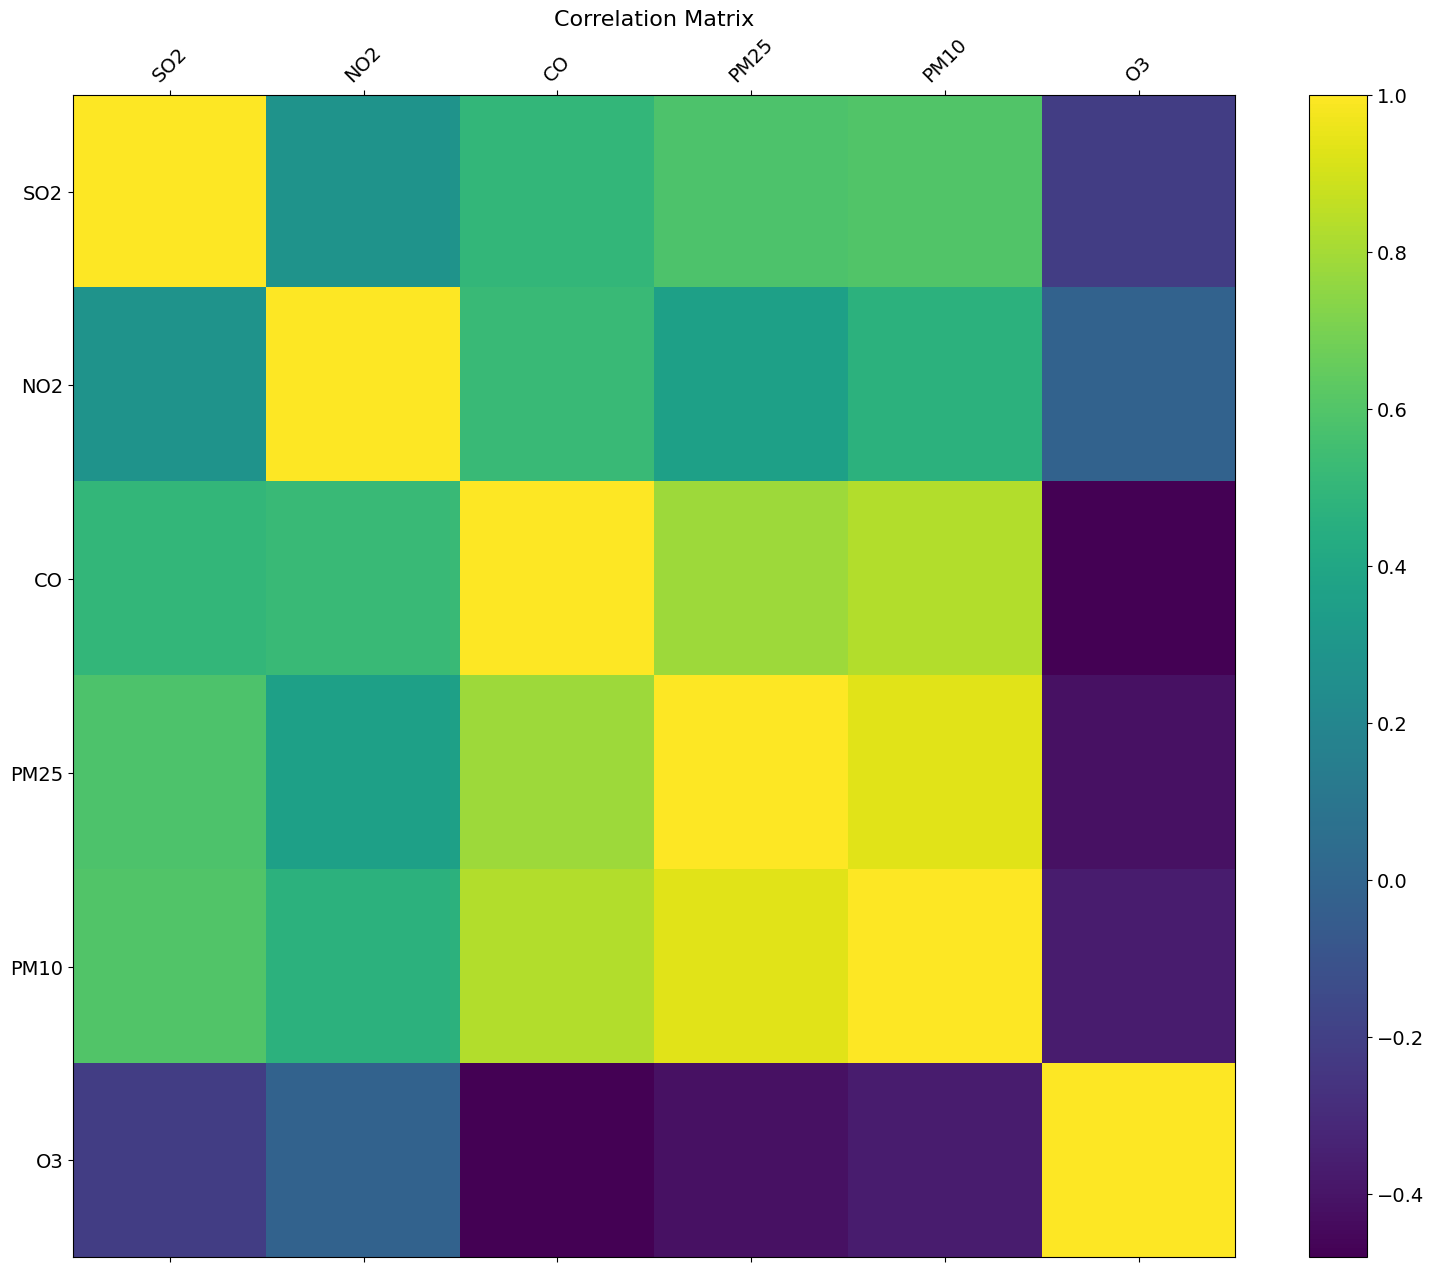

In [98]:
import matplotlib.pyplot as plt
df = final_df
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [99]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_1160353/1988838957.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


<AxesSubplot:>

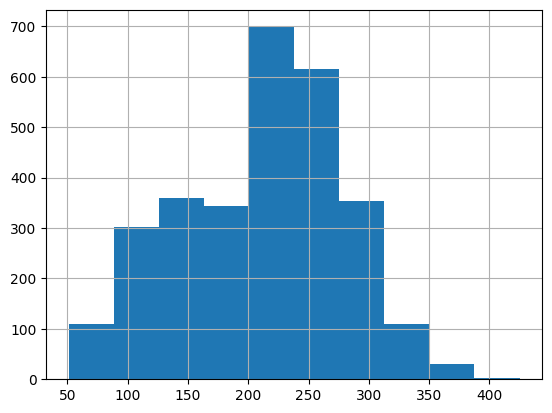

In [103]:
final_df['max_value'] = final_df.max(axis=1)
final_df.max_value.hist()

Przygotowanie danych do treningu, model autoregresywny patrzący 2 dni do tyłu

In [104]:
dataframe = pd.concat([final_df.shift(2),final_df.shift(1), final_df], axis=1) 
dataframe = dataframe.dropna(axis=0)

In [105]:
dataframe

SO2   NO2     CO   PM25  PM10     O3  max_value    SO2   NO2  \
2015-01-03  56.0  55.0  148.0  122.0  45.0   43.0      148.0   62.0  36.0   
2015-01-04  62.0  36.0  103.0   74.0  18.0  146.0      146.0   29.0  38.0   
2015-01-05  29.0  38.0   79.0   62.0  16.0  209.0      209.0   56.0  15.0   
2015-01-06  56.0  15.0   68.0   49.0   8.0  224.0      224.0   43.0  42.0   
2015-01-07  43.0  42.0   85.0   60.0  13.0  207.0      207.0  103.0  37.0   
...          ...   ...    ...    ...   ...    ...        ...    ...   ...   
2022-12-27  61.0  27.0   64.0   63.0  21.0  163.0      163.0   40.0  32.0   
2022-12-28  40.0  32.0   60.0   58.0  14.0  179.0      179.0   47.0  36.0   
2022-12-29  47.0  36.0   58.0   47.0  15.0  216.0      216.0   35.0  44.0   
2022-12-30  35.0  44.0  127.0   53.0  16.0  177.0      177.0   33.0  26.0   
2022-12-31  33.0  26.0   48.0   54.0  18.0  200.0      200.0   30.0  48.0   

               CO  ...  PM10     O3  max_value  SO2  NO2   CO  PM25  PM10  \
2015-01-03  103.0  ...  18.0  146.0      146.0   29   38   79    62    16   
2015-01-04   79.0  ...  16.0  209.0      209.0   56   15   68    49     8   
2015-01-05   68.0  ...   8.0  224.0      224.0   43   42   85    60    13   
2015-01-06   85.0  ...  13.0  207.0      207.0  103   37  104    89    34   
2015-01-07  104.0  ...  34.0  177.0      177.0  163  102  128   155    57   
...           ...  ...   ...    ...        ...  ...  ...  ...   ...   ...   
2022-12-27   60.0  ...  14.0  179.0      179.0   47   36   58    47    15   
2022-12-28   58.0  ...  15.0  216.0      216.0   35   44  127    53    16   
2022-12-29  127.0  ...  16.0  177.0      177.0   33   26   48    54    18   
2022-12-30   48.0  ...  18.0  200.0      200.0   30   48   56    63    22   
2022-12-31   56.0  ...  22.0  104.0      104.0   62   17   42    53    12   

             O3  max_value  
2015-01-03  209        209  
2015-01-04  224        224  
2015-01-05  207        207  
2015-01-06  177        177  
2015-01-07   58        163  
...         ...        ...  
2022-12-27  216        216  
2022-12-28  177        177  
2022-12-29  200        200  
2022-12-30  104        104  
2022-12-31  159        159  

[2920 rows x 21 columns]

In [107]:
def xy(test):
    return test.iloc[:,:-7], test.iloc[:,-1:]
train = dataframe[dataframe.index < '2022-01-01']
test = dataframe[dataframe.index >= '2022-01-01']
x_train, y_train = xy(train)
x_test, y_test = xy(test)

In [110]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
 

mse_list = []
mae_list = []
r2_list = []
for regressor in [RandomForestRegressor(), LinearRegression(), GradientBoostingRegressor()]:
    print(regressor)
    regressor.fit(x_train, y_train)

    predictions_train = regressor.predict(x_train)
    predictions_test = regressor.predict(x_test)

    # Evaluating the model
    mse = mean_squared_error(y_train, predictions_train)
    print(f'Mean Squared Error Train: {mse}')
    mae = mean_absolute_error(y_train, predictions_train)
    print(f'Mean A Error Train: {mae}')
    r2 = r2_score(y_train, predictions_train)
    print(f'R-squared Train: {r2}')

    mse = mean_squared_error(y_test, predictions_test)
    print(f'Mean Squared Error Test: {mse}')
    mae = mean_absolute_error(y_test, predictions_test)
    print(f'Mean A Error Test: {mae}')
    r2 = r2_score(y_test, predictions_test)
    print(f'R-squared Test: {r2}')
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)


RandomForestRegressor()
Mean Squared Error Train: 222.3058413307241
Mean A Error Train: 11.518606653620353
R-squared Train: 0.9502769602331131
Mean Squared Error Test: 1402.4327005479454
Mean A Error Test: 29.676027397260274
R-squared Test: 0.7090269533472173
LinearRegression()
Mean Squared Error Train: 1576.4829489376168
Mean A Error Train: 30.493018967824817
R-squared Train: 0.6473888230169029
Mean Squared Error Test: 1397.0276248921691
Mean A Error Test: 28.89885040649135
R-squared Test: 0.7101483842225353
GradientBoostingRegressor()
Mean Squared Error Train: 1222.6629833639486
Mean A Error Train: 27.25448126199905
R-squared Train: 0.7265275632012643
Mean Squared Error Test: 1437.1115045585295
Mean A Error Test: 29.886917032646988
R-squared Test: 0.7018318863373766


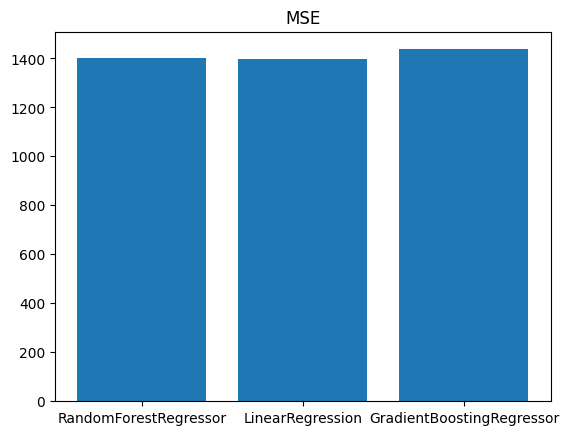

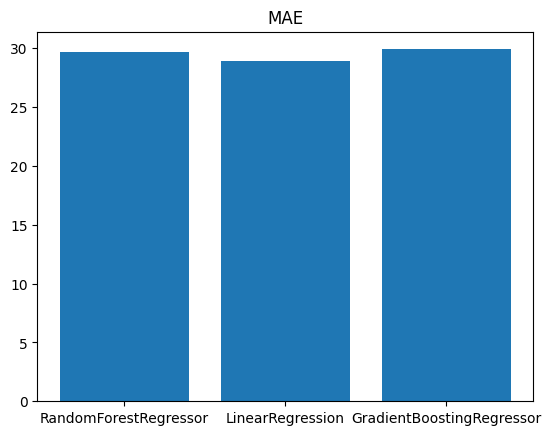

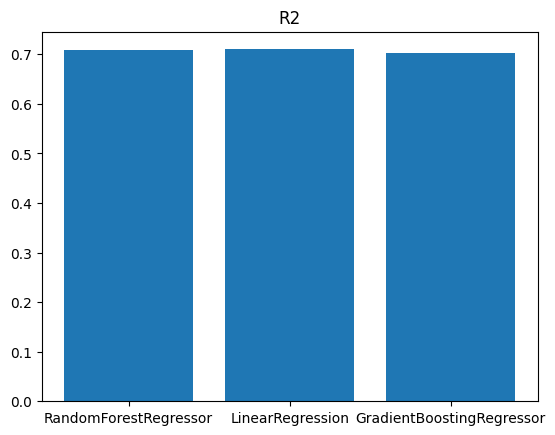

In [111]:
x = ['RandomForestRegressor', 'LinearRegression', 'GradientBoostingRegressor']
plt.bar(x,mse_list)
plt.title("MSE")
plt.show()

plt.bar(x,mae_list)
plt.title("MAE")
plt.show()

plt.bar(x,r2_list)
plt.title("R2")
plt.show()

Badanie wpływu długości analizowanej historii na wynik

In [138]:
from collections import defaultdict
mse_list = defaultdict(list)
mae_list = defaultdict(list)
r2_list = defaultdict(list)
ANAL_STEP = [1,2,3,4,5,6,7,8,9,10,15,20,25]
for steps in ANAL_STEP:
	list_df = [final_df.shift(i) for i in range (1,steps+1)]
	list_df.append(final_df)
	dataframe = pd.concat(list_df, axis=1) 
	dataframe = dataframe.dropna(axis=0)
	train = dataframe[dataframe.index < '2022-01-01']
	test = dataframe[dataframe.index >= '2022-01-01']
	def xy(test):
	    return test.iloc[:,:-7], test.iloc[:,-1:]
	x_train, y_train = xy(train)
	x_test, y_test = xy(test)


	for regressor in [RandomForestRegressor(), LinearRegression(), GradientBoostingRegressor()]:
	    regressor.fit(x_train, y_train)
	    predictions_test = regressor.predict(x_test)


	    mse = mean_squared_error(y_test, predictions_test)
	    print(f'Mean Squared Error Test: {mse}')
	    mae = mean_absolute_error(y_test, predictions_test)
	    print(f'Mean A Error Test: {mae}')
	    r2 = r2_score(y_test, predictions_test)
	    print(f'R-squared Test: {r2}')
	    regressor = regressor.__class__.__name__
	    mse_list[regressor].append(mse)
	    mae_list[regressor].append(mae)
	    r2_list[regressor].append(r2)

RandomForestRegressor()
Mean Squared Error Test: 1532.708502191781
Mean A Error Test: 31.081616438356168
R-squared Test: 0.6819976728016126
LinearRegression()
Mean Squared Error Test: 1456.2043053698055
Mean A Error Test: 29.628085523077218
R-squared Test: 0.6978705622617036
GradientBoostingRegressor()
Mean Squared Error Test: 1442.1746898864722
Mean A Error Test: 30.042823238066173
R-squared Test: 0.7007813899677016
RandomForestRegressor()
Mean Squared Error Test: 1416.2174334246577
Mean A Error Test: 29.80767123287671
R-squared Test: 0.7061669332401102
LinearRegression()
Mean Squared Error Test: 1397.0276248921691
Mean A Error Test: 28.89885040649135
R-squared Test: 0.7101483842225353
GradientBoostingRegressor()
Mean Squared Error Test: 1432.474540616918
Mean A Error Test: 29.86022390031061
R-squared Test: 0.7027939514152821
RandomForestRegressor()
Mean Squared Error Test: 1426.5121693150686
Mean A Error Test: 29.80449315068493
R-squared Test: 0.7040310085249005
LinearRegression()
Me

[1532.708502191781, 1416.2174334246577, 1426.5121693150686, 1422.2525126027397, 1360.0897589041097, 1335.273664383562, 1294.2530326027397, 1281.7617400000001, 1253.9942632876714, 1266.2756071232877, 1296.4086698630138, 1287.2100983561645, 1248.5962895890411]
[1456.2043053698055, 1397.0276248921691, 1390.854209112769, 1392.6983727119352, 1368.0982118893044, 1357.471000995174, 1330.8807711556358, 1320.4054757275846, 1320.8338832386773, 1331.3301678495593, 1321.2224377232487, 1353.4196274156247, 1363.5452523598067]
[1442.1746898864722, 1432.474540616918, 1421.5617065929882, 1408.2201787288252, 1331.1023686336732, 1312.0947801405175, 1339.4506526415062, 1271.0214974882394, 1279.6093650282503, 1266.7569596570297, 1293.8406649806268, 1295.0158137378603, 1272.5288647337543]


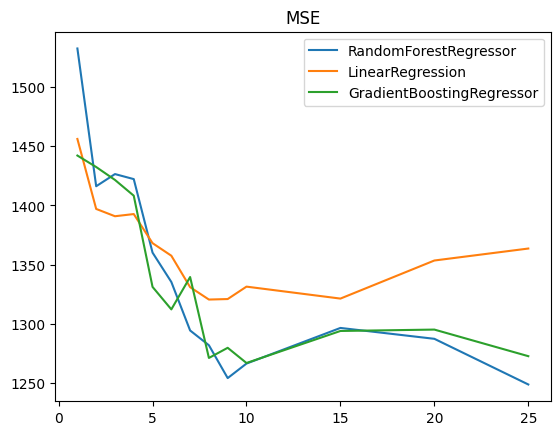

[31.081616438356168, 29.80767123287671, 29.80449315068493, 29.95, 29.110410958904108, 28.954328767123286, 28.30002739726027, 28.32243835616438, 27.98994520547945, 27.99282191780822, 28.42112328767123, 28.365671232876714, 27.92276712328767]
[29.628085523077218, 28.89885040649135, 28.809256249571387, 28.93588619374086, 28.601159711772045, 28.718650256060254, 28.309030730139874, 28.13780004185271, 28.138015746805966, 28.20588830117341, 27.867619272405904, 28.177886991492713, 28.123474993861958]
[30.042823238066173, 29.86022390031061, 29.913922555087762, 29.71539591893833, 28.787176807527242, 28.52886098685872, 28.827222582561898, 27.797969616644313, 27.96928775422288, 27.84032771362171, 28.217952603317443, 28.05106446340372, 27.819136590173873]


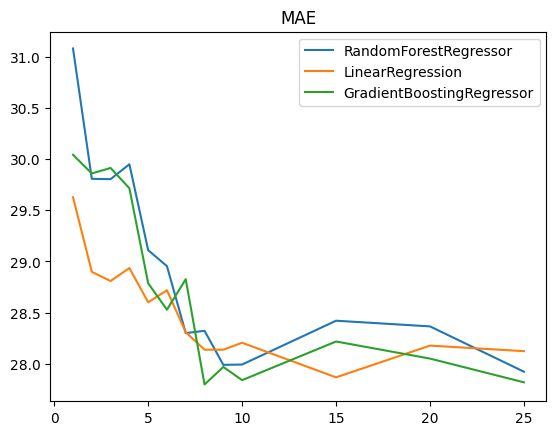

[0.6819976728016126, 0.7061669332401102, 0.7040310085249005, 0.7049147908916387, 0.7178121554674575, 0.7229609334628978, 0.7314717862119988, 0.7340634467343401, 0.7398245697413048, 0.7372764688367528, 0.7310245402651131, 0.7329330356782304, 0.7409445271212407]
[0.6978705622617036, 0.7101483842225353, 0.7114292282850594, 0.7110466060738361, 0.7161505827137936, 0.7183554884679724, 0.7238723593913224, 0.7260457461243166, 0.7259568612611336, 0.7237791197477121, 0.7258762449990326, 0.7191960567983525, 0.7170952187773046]
[0.7007813899677016, 0.7027939514152821, 0.705058117504905, 0.7078261826021619, 0.7238263829296427, 0.7277700273777614, 0.7220943029295595, 0.7362918039911381, 0.7345100158301867, 0.7371765990795786, 0.7315573431612202, 0.7313135263891007, 0.7359790594011976]


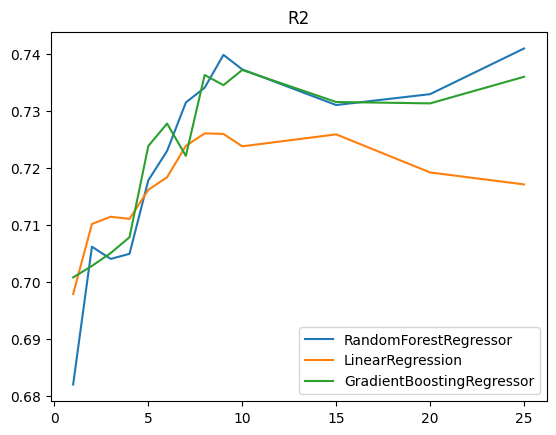

In [139]:
for name, measure in [('MSE',mse_list), ('MAE',mae_list), ('R2',r2_list)]:
    for regressor, val in measure.items():
        plt.plot(ANAL_STEP,val, label=regressor)
    plt.title(name)
    plt.legend()
    plt.show()

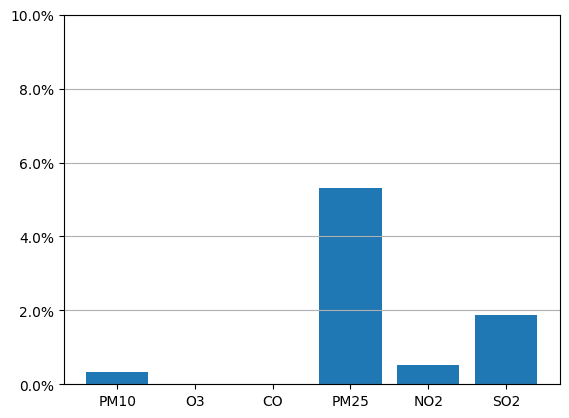

In [68]:
def missing_data_plots(missing_data_dict: dict):
    x = list(missing_data_dict.keys())
    y = [round(data_miss / data_size * 100, 2) for (data_miss, data_size) in missing_data_dict.values()]
    plt.bar(x, y)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100))
    ax.yaxis.grid(True)
    plt.ylim(0, 10)
    # plt.show()
    plt.savefig('missing_data.png')
    
missing_data_plots(missing_data)